In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import roc_curve, auc

In [2]:
import pandas as pd
import numpy as np
import ast
import json
from geopy.distance import geodesic

In [3]:
eval_pack = pd.read_csv(r'D:\UH_Madagascar\Data\validation_data\validation_pack_cleaned_final.csv')

eval_pack


,id,ent_start,ent_end,ent_label,place_names,p_lat,p_lon,g_lat,g_lon,n_lat,...,comments,bbox_WoF,bbox_GN,bbox,combine_pel,combine_nom,combine_gn,distance_pel,distance_gn,distance_nom
0,321,64,74,GPE,Madagascar,-18.628414,46.704055,-20.0,47.0,-18.92496,...,-,0,"{'east': 50.486374859, 'south': -25.604970374,...",0,True,True,True,154.981542,0.0,132.661065
1,351,2269,2279,GPE,Madagascar,-18.628414,46.704055,-20.0,47.0,-18.92496,...,-,0,"{'east': 50.486374859, 'south': -25.604970374,...",0,True,True,True,154.981542,0.0,132.661065
2,351,1657,1667,GPE,Madagascar,-18.628414,46.704055,-20.0,47.0,-18.92496,...,-,0,"{'east': 50.486374859, 'south': -25.604970374,...",0,True,True,True,154.981542,0.0,132.661065
3,371,78,88,GPE,Madagascar,-18.628414,46.704055,-20.0,47.0,-18.92496,...,-,0,"{'east': 50.486374859, 'south': -25.604970374,...",0,True,True,True,154.981542,0.0,132.661065
4,462,87,97,LOC,Madagascar,-18.628414,46.704055,-20.0,47.0,-18.92496,...,-,0,"{'east': 50.486374859, 'south': -25.604970374,...",0,True,True,True,154.981542,0.0,132.661065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,14121,0,14,LOC,P185 - Bourses,0.000000,0.000000,0.0,0.0,0.00000,...,0,0,0,0,False,False,False,NaN,NaN,NaN
211,14121,84,97,LOC,Campus France,0.000000,0.000000,0.0,0.0,0.00000,...,0,0,0,0,False,False,False,NaN,NaN,NaN
212,14145,0,0,0,0,0.000000,0.000000,0.0,0.0,0.00000,...,-,0,0,0,False,False,False,NaN,NaN,NaN
213,14242,0,0,0,0,0.000000,0.000000,0.0,0.0,0.00000,...,-,0,"{'east': 50.486374859, 'south': -25.604970374,...",0,False,False,False,NaN,NaN,NaN


In [ ]:
# definition for distance calculation to apply on the field

def calculate_distance_p(row):
    if (row['lat'] == 0.0 and row['lon'] == 0.0) or (row['p_lat'] == 0.0 and row['p_lon'] == 0.0):
        return None
    return geodesic((row['lat'], row['lon']), (row['p_lat'], row['p_lon'])).kilometers 

def calculate_distance_g(row):
    if (row['lat'] == 0.0 and row['lon'] == 0.0) or (row['g_lat'] == 0.0 and row['g_lon'] == 0.0):
        return None
    return geodesic((row['lat'], row['lon']), (row['g_lat'], row['g_lon'])).kilometers 
    
def calculate_distance_n(row):
    if (row['lat'] == 0.0 and row['lon'] == 0.0) or (row['n_lat'] == 0.0 and row['n_lon'] == 0.0):
        return None
    return geodesic((row['lat'], row['lon']), (row['n_lat'], row['n_lon'])).kilometers 


In [ ]:
# Applying the definition of  distance calculator 
# Returns error distances for geocoded locations from the ground truth - is already in the imported dataset

eval_pack['distance_pel'] = eval_pack.apply(calculate_distance_p, axis = 1)
eval_pack['distance_gn'] = eval_pack.apply(calculate_distance_g, axis = 1)
eval_pack['distance_nom'] = eval_pack.apply(calculate_distance_n, axis = 1)

In [ ]:
#eval_pack.to_csv(r'D:\UH_Madagascar\Data\validation_data\validation_pack_cleaned_final.csv', encoding = 'utf-8', index = False, float_format="%.6f")

In [ ]:
# The distance datatypes were changed some how so here I ensure that they will be written in float

eval_pack['distance_gn'] = eval_pack['distance_gn'].astype(float)
eval_pack['distance_pel'] = eval_pack['distance_pel'].astype(float)
eval_pack['distance_nom'] = eval_pack['distance_nom'].astype(float)
#eval_pack.to_csv("test2.csv", index=False, float_format="%.6f")

In [ ]:
eval_pack['distance_nom'].median()

In [5]:
# Selecting locations for AUC evaluation considering all ground truth locations and geocoded locations that are not on 0.0 longitude 
#(covers only locations in Madagascar and if there is any)

gn_hits = eval_pack.loc[(eval_pack['lon'] != 0) + (eval_pack['g_lon'] != 0)]
pel_hits = eval_pack.loc[(eval_pack['lon'] != 0) + (eval_pack['p_lon'] != 0)]
nom_hits = eval_pack.loc[(eval_pack['lon'] != 0) + (eval_pack['n_lon'] != 0)]


In [23]:
# Calculating the score based on error distance - it is now positive so it has to be inverted for AUC analysis

nom_hits['nom_score'] = (nom_hits['distance_nom'] / pel_hits['distance_pel'].max()) * 100
pel_hits['pel_score'] = (pel_hits['distance_pel'] / pel_hits['distance_pel'].max()) * 100
gn_hits['gn_score'] = (gn_hits['distance_gn'] / pel_hits['distance_pel'].max()) * 100



C:\Users\iidahava\AppData\Local\Temp\ipykernel_7376\799187752.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nom_hits['nom_score'] = (nom_hits['distance_nom'] / pel_hits['distance_pel'].max()) * 100
C:\Users\iidahava\AppData\Local\Temp\ipykernel_7376\799187752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pel_hits['pel_score'] = (pel_hits['distance_pel'] / pel_hits['distance_pel'].max()) * 100
C:\Users\iidahava\AppData\Local\Temp\ipykernel_7376\799187752.py:5: SettingWithCopyWarning: 
A value is 

In [ ]:
nom_hits['distance_nom']

In [6]:
# Using Madagascar length for logged error distance
MDGl = 1600

nom_hits['nom_score'] = (nom_hits['distance_nom'] / MDGl) * 100
pel_hits['pel_score'] = (pel_hits['distance_pel'] / MDGl) * 100
gn_hits['gn_score'] = (gn_hits['distance_gn'] / MDGl) * 100

C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\2318295164.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nom_hits['nom_score'] = (nom_hits['distance_nom'] / MDGl) * 100
C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\2318295164.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pel_hits['pel_score'] = (pel_hits['distance_pel'] / MDGl) * 100
C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\2318295164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [33]:
pel_hits['distance_pel'].max()

715.828479

In [ ]:
#nom_hits['nom_score']
pel_hits['pel_score']

In [7]:
# Reversing scores so they will represent true score 

nom_hits['nom_score'] = 100 - nom_hits['nom_score']
pel_hits['pel_score'] = 100 - pel_hits['pel_score']
gn_hits['gn_score'] = 100 - gn_hits['gn_score']

nom_hits['nom_score']

C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\250662839.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nom_hits['nom_score'] = 100 - nom_hits['nom_score']
C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\250662839.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pel_hits['pel_score'] = 100 - pel_hits['pel_score']
C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\250662839.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

0      91.708683
1      91.708683
2      91.708683
3      91.708683
4      91.708683
         ...    
194          NaN
195          NaN
204          NaN
209          NaN
213          NaN
Name: nom_score, Length: 77, dtype: float64

In [8]:
# Roc-curve expects values on a scale form 0 to 1

nom_hits['nom_score'] = nom_hits['nom_score'] / 100
pel_hits['pel_score'] = pel_hits['pel_score'] / 100
gn_hits['gn_score'] = gn_hits['gn_score'] / 100

C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\1114044540.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nom_hits['nom_score'] = nom_hits['nom_score'] / 100
C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\1114044540.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pel_hits['pel_score'] = pel_hits['pel_score'] / 100
C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\1114044540.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [ ]:
print(nom_hits['nom_score'])


In [9]:
# Figuring out which would be the best way to present Nans that are misleadinlgy turned to 0.0 coordinates. 
# Could be presented as neutral (50) or just (0) or (100)

#nom_hits = nom_hits.dropna(subset=['nom_score'])
#pel_hits = pel_hits.dropna(subset=['pel_score'])
#gn_hits = gn_hits.dropna(subset=['gn_score'])

#nom_hits = nom_hits.dropna(subset=['nom_score'])
#pel_hits = pel_hits.dropna(subset=['pel_score'])
#gn_hits = gn_hits.dropna(subset=['gn_score'])
nom_hits['nom_score'] = nom_hits['nom_score'].fillna(0.08)
pel_hits['pel_score'] = pel_hits['pel_score'].fillna(0.08)
gn_hits['gn_score'] = gn_hits['gn_score'].fillna(0.08)

C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\158653535.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nom_hits['nom_score'] = nom_hits['nom_score'].fillna(0.08)
C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\158653535.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pel_hits['pel_score'] = pel_hits['pel_score'].fillna(0.08)
C:\Users\iidahava\AppData\Local\Temp\ipykernel_1844\158653535.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

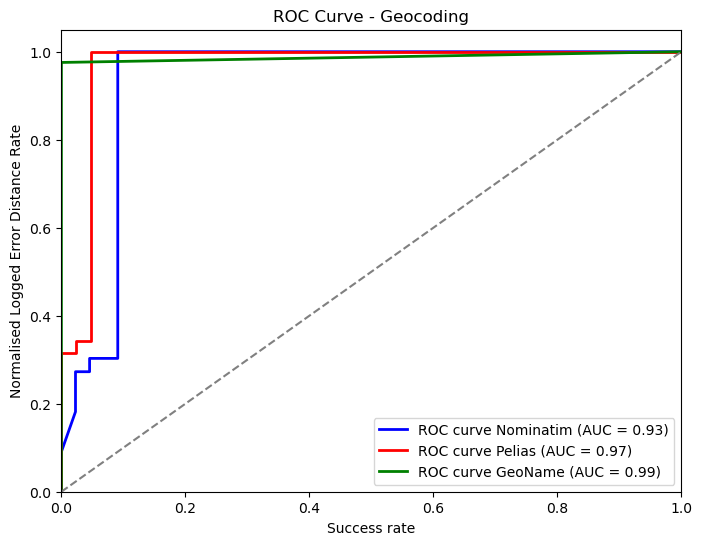

In [10]:
# Toponym recognition calculations

truer1, edr1, tresholds1 = roc_curve((nom_hits['combine_nom']), (nom_hits['nom_score']))
truer2, edr2, tresholds2 = roc_curve((pel_hits['combine_pel']), (pel_hits['pel_score']))
truer3, edr3, tresholds3 = roc_curve((gn_hits['combine_gn']), (gn_hits['gn_score']))

roc_auc_nom = auc(truer1, edr1)
roc_auc_pel = auc(truer2, edr2)
roc_auc_gn = auc(truer3, edr3)


plt.figure(figsize = (8,6))
plt.plot(truer1, edr1, color = 'blue', lw = 2, label = f'ROC curve Nominatim (AUC = {roc_auc_nom:.2f})')
plt.plot(truer2, edr2, color = 'red', lw = 2, label = f'ROC curve Pelias (AUC = {roc_auc_pel:.2f})')
plt.plot(truer3, edr3, color = 'green', lw = 2, label = f'ROC curve GeoName (AUC = {roc_auc_gn:.2f})')
plt.plot([0, 1], [0, 1], color = 'gray', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Success rate')
plt.ylabel('Normalised Logged Error Distance Rate')
plt.title('ROC Curve - Geocoding')
plt.legend(loc= 'lower right')

plt.savefig('AUC_results_original_err_nan008_round.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# Toponym recognition calculations

truer1, edr1, tresholds1 = roc_curve((nom_hits['combine_nom']), (nom_hits['nom_score']))
truer2, edr2, tresholds2 = roc_curve((pel_hits['combine_pel']), (pel_hits['pel_score']))
truer3, edr3, tresholds3 = roc_curve((gn_hits['combine_gn']), (gn_hits['gn_score']))

roc_auc_nom = auc(truer1, edr1)
roc_auc_pel = auc(truer2, edr2)
roc_auc_gn = auc(truer3, edr3)


plt.figure(figsize = (8,6))
plt.plot(truer1, edr1, color = 'blue', lw = 2, label = f'ROC curve Nominatim (AUC = {roc_auc_nom:.2f})')
plt.plot(truer2, edr2, color = 'red', lw = 2, label = f'ROC curve Pelias (AUC = {roc_auc_pel:.2f})')
plt.plot(truer3, edr3, color = 'green', lw = 2, label = f'ROC curve GeoName (AUC = {roc_auc_gn:.2f})')
plt.plot([0, 1], [0, 1], color = 'gray', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Success rate')
plt.ylabel('Normalised Logged Error Distance Rate (0 = 20039 km, 1 = 0 km)')
plt.title('ROC Curve for Toponym Recognition')
plt.legend(loc= 'upper left')

plt.savefig('AUC_results_nan100_noround2.png', dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import os
print(os.getcwd())

In [ ]:
eval_pack2 = eval_pack.loc[(eval_pack['place_names'] != '0')]
eval_pack2 = eval_pack2.loc[(eval_pack2['lat'] != 0)]
eval_pack2
p_pack = eval_pack2.loc[(eval_pack2['p_lat'] == 0)]
g_pack = eval_pack2.loc[(eval_pack2['g_lat'] == 0)]
n_pack = eval_pack2.loc[(eval_pack2['n_lat'] == 0)]
p_pack

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Updated scenario: 15 total values
# 6 positives, 9 negatives with mixed scores

y_true_updated = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]  # 6 positives (1), 9 negatives (0)
y_score_updated = [0.87, 0.87, 0.87, 0.87, 0.5, 0.5, 0.5, 0.5, 0.08, 0.08, 0.5, 0.5, 0.4, 0.4, 0.08]  # mixed scores

# Calculate ROC curve and AUC
fpr_updated, tpr_updated, thresholds_updated = roc_curve(y_true_updated, y_score_updated)
auc_updated = roc_auc_score(y_true_updated, y_score_updated)

# Plotting the updated ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr_updated, tpr_updated, marker='o', label=f"AUC = {auc_updated:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve (6 positives, 9 negatives with mixed scores)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
